<center><font size="15"><b>Классификация видеороликов для компании СОЮЗМУЛЬТФИЛЬМ</b></font></center>

Студия для оценки популярности проектов мониторит рынок и собирает статистику.   
**Цель работы** – создать модель машинного обучения для классификации видеороликов с платформы **YouTube** по критерию принадлежности к проекту компании.  
**Задачи:**
1. Изучить полученные датасеты train и test.
2. Провести предобработку данных для исключения ошибок.
3. Провести исследовательский анализ данных.
4. При необходимости собрать дополнительные данные.

# Описание данных

| Имя признака    | Описание                                                                         |
|-----------------|----------------------------------------------------------------------------------|
| date            | дата, когда ролик появился на ютубе                                              |
| reel_name       | название ролика                                                                  |
| yt_reel_id      | уникальный идентификатор ролика на ютубе                                         |
| cartoon         | название проекта, целевая переменная                                             |
| url             | ссылка на ролик (включает идентификатор)                                         |
| text            | текст сниппета, включает название ролика и описание                              |
| seconds         | длительность                                                                     |
| is_shorts       | вертикальные видеоролики продолжительностью <60сек                               |
| broadcast       | лайвы, прямые эфиры                                                              |
| yt_channel_id   | идентификатор ютуб канала                                                        |
| yt_channel_name | название ютуб канала                                                             |
| yt_ch_url       | ссылка на ютуб канал                                                             |
| yt_channel_type | тип канала (Мультфильмы, Детские, Блогеры, Shorts…)                              |
| flag_closed     | ютуб канал закрыт, если 1                                                        |
| international   | метка международных каналов, каналов на иностранном языке (переведенный контент) |
| language        | язык                                                                             |

## Импорт модулей

In [1]:
import pickle
import re
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from tqdm.autonotebook import tqdm
from wordcloud import WordCloud

# from xgboost import XGBClassifier

%matplotlib inline

tqdm.pandas()

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.svm import SVC

# from sentence_transformers import SentenceTransformer
# from keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from torch import load, save

pd.options.display.float_format = "{:,.2f}".format
RANDOM_STATE = 23102024

## Указание пути к файлам

In [2]:
train_path = "C:/Users/Jemiah/Союзмультфильм/data/train.csv"
test_path = "C:/Users/Jemiah/Союзмультфильм/data/test.csv"

## Загрузка наборов данных

In [3]:
raw_train = pd.read_csv(train_path, lineterminator="\n")

In [4]:
raw_test = pd.read_csv(test_path, lineterminator="\n")

# Анализ и предобработка (train)


## Пропуски в данных

In [5]:
print(raw_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB
None


In [6]:
raw_train.isna().sum() / raw_train.shape[0] * 100

date               0.00
reel_name          0.00
yt_reel_id         0.00
cartoon            0.00
url                0.00
text               0.00
seconds           10.50
is_shorts         10.50
broadcast         10.50
yt_channel_id      0.05
yt_channel_name    0.06
yt_ch_url          0.06
yt_channel_type    0.06
flag_closed        0.06
international      0.06
language          99.40
dtype: float64

1. **seconds, is_shorts, broadcast** – около 10.5 % пропусков
2. **language** ~ 99% пропусков. Есть смысл написать функцию которая определит языковую принадлежность текста/канала.

## Дубликаты

In [7]:
print("Дубликаты по названию ролика:", raw_train.duplicated(["reel_name"]).sum())
print("Дубликаты по идентификатору ролика:", raw_train.duplicated(["yt_reel_id"]).sum())

Дубликаты по названию ролика: 6188
Дубликаты по идентификатору ролика: 0


In [8]:
raw_train.loc[
    raw_train.loc[:, "reel_name"] == "Руслан и Людмила. Больше, чем сказка  Shorts",
    "text",
]

7569     [Руслан и Людмила. Больше, чем сказка  Shorts]...
21022    [Руслан и Людмила. Больше, чем сказка  Shorts]...
23748    [Руслан и Людмила. Больше, чем сказка  Shorts]...
24590    [Руслан и Людмила. Больше, чем сказка  Shorts]...
24795    [Руслан и Людмила. Больше, чем сказка  Shorts]...
41509    [Руслан и Людмила. Больше, чем сказка  Shorts]...
48331    [Руслан и Людмила. Больше, чем сказка  Shorts]...
48394    [Руслан и Людмила. Больше, чем сказка  Shorts]...
62702    [Руслан и Людмила. Больше, чем сказка  Shorts]...
71541    [Руслан и Людмила. Больше, чем сказка  Shorts]...
77491    [Руслан и Людмила. Больше, чем сказка  Shorts]...
81643    [Руслан и Людмила. Больше, чем сказка  Shorts]...
82776    [Руслан и Людмила. Больше, чем сказка  Shorts]...
82792    [Руслан и Людмила. Больше, чем сказка  Shorts]...
83348    [Руслан и Людмила. Больше, чем сказка  Shorts]...
Name: text, dtype: object

In [9]:
raw_train.iloc[7569]["text"] == raw_train.iloc[81643]["text"]

True

Некоторые каналы дублируют ролики в виде рекламы. Зачастую они содержат одну и ту же информацию и могут быть удалены.

In [10]:
cleaned_train = raw_train.drop_duplicates(["reel_name"]).reset_index(drop=True)

## Числовые признаки

Для начала посмотрим на распределения числовых признаков. Признаки is_shorts, flag_closed, international имеют бинарный характер.

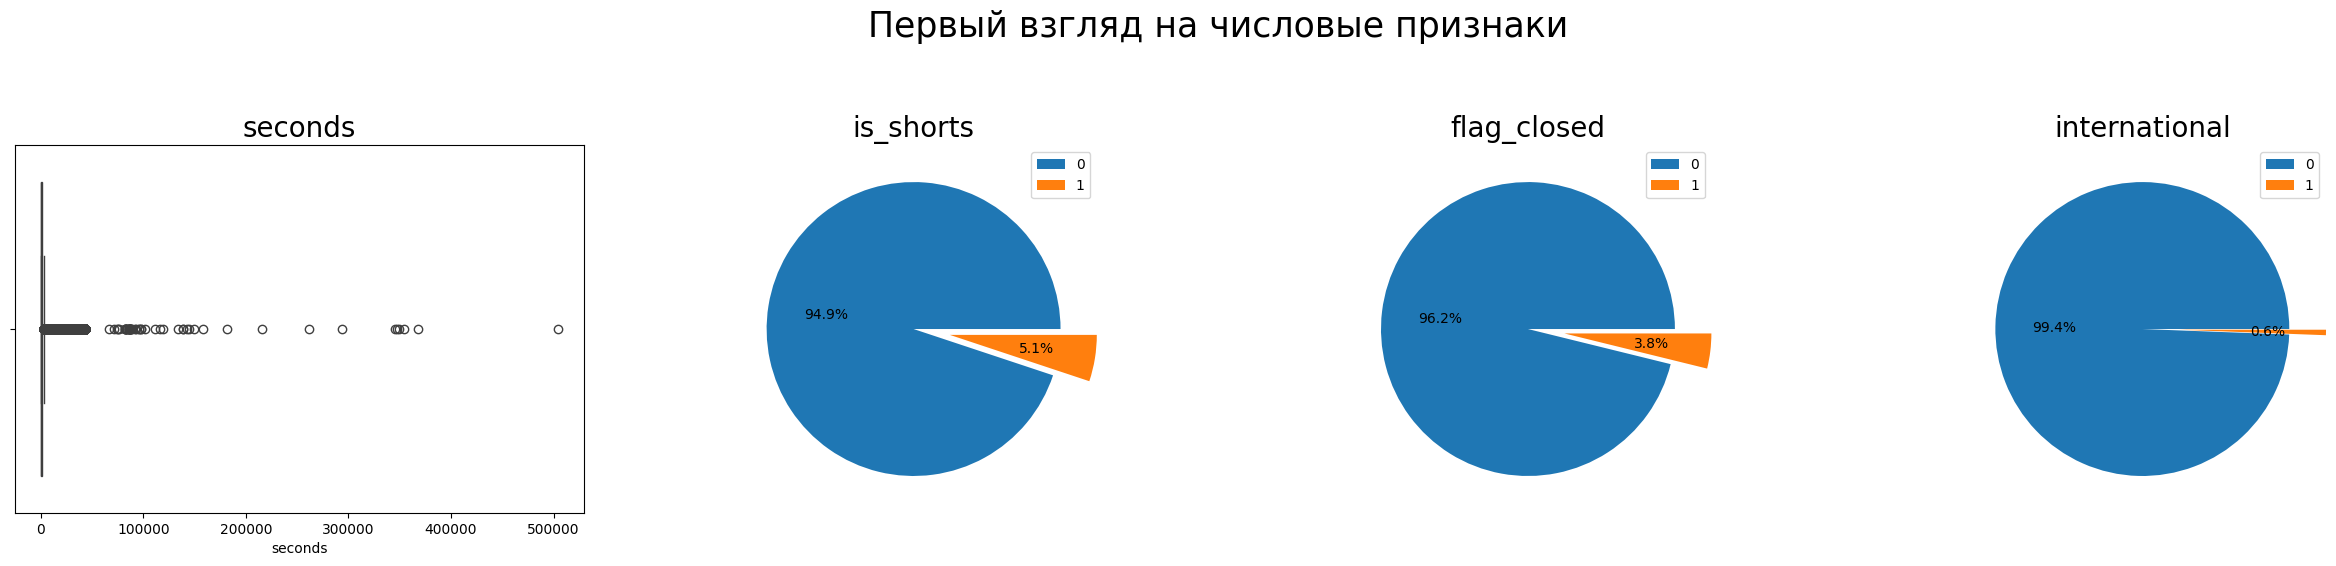

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 6))
for i, col in enumerate(raw_train.select_dtypes("float64").columns):
    if col == "seconds":
        sns.boxplot(raw_train[col], ax=axs[i], orient="h")
        axs[i].set_title(col, size=20)
    else:
        axs[i].pie(
            x=[
                raw_train[raw_train[col] == 0][col].shape[0],
                raw_train[raw_train[col] == 1][col].shape[0],
            ],
            autopct="%1.1f%%",
            explode=[0, 0.25],
        )
        axs[i].set_title(col, size=20)
        axs[i].legend([0, 1])

plt.suptitle("Первый взгляд на числовые признаки", size=25)
plt.tight_layout(pad=3.0)
plt.show()

Для более детального изучения (этих на скорую руку построенных графиков) я использовал дабл-клик по картинке.

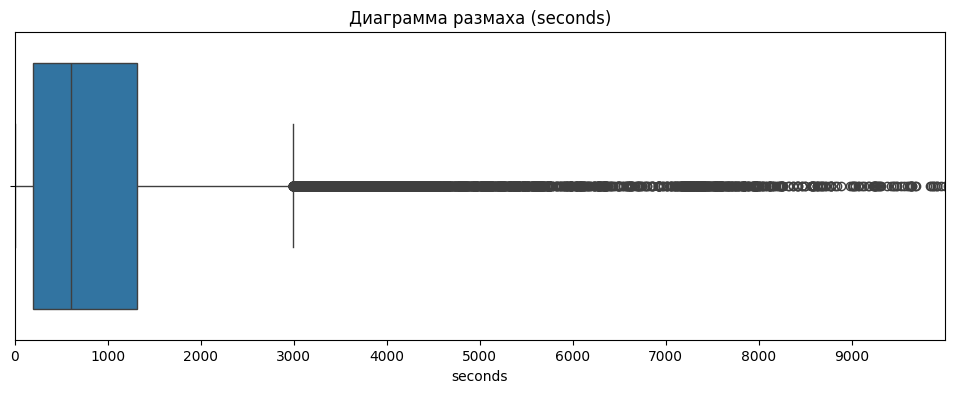

In [12]:
plt.figure(figsize=(12, 4))
sns.boxplot(raw_train["seconds"], orient="h")
plt.title("Диаграмма размаха (seconds)")
plt.xlim(0, 10000)
plt.xticks(range(0, 10000, 1000))
plt.show()

In [13]:
# статистики по секундам
display(pd.DataFrame(raw_train["seconds"].describe()))

,seconds
count,"74,653.00"
mean,"1,921.29"
std,"7,097.90"
min,0.00
25%,200.00
50%,602.00
75%,"1,316.00"
max,"504,055.00"


In [14]:
# сколько данных лежит на пределами "усов"
raw_train.loc[raw_train.seconds > 3000, "seconds"].shape[0] / raw_train.shape[0] * 100

8.612772895661244

In [15]:
# проверка на адекватность
print(
    "Кол-во роликов с меткой shorts = 1, не удовлетворяющих условиям платформы:",
    raw_train.query("is_shorts == 1 and (seconds < 15 or seconds > 60)").shape[0],
)

print(
    "Кол-во роликов с меткой shorts = 0, не удовлетворяющих условиям платформы:",
    raw_train.query(
        "is_shorts == 0 and (seconds == 0 or seconds > 12 * 60 * 60)"
    ).shape[0],
)

Кол-во роликов с меткой shorts = 1, не удовлетворяющих условиям платформы: 886
Кол-во роликов с меткой shorts = 0, не удовлетворяющих условиям платформы: 1818


При попытке ручной верификации соответствия типа ролика его метке (из полученного выше списка) было обнаружено, что множество роликов удалены или доступ к ним запрещён.

In [16]:
print(
    "Кол-во видеороликов длиной больше 12 ч:",
    int((raw_train.seconds > (12 * 60 * 60)).sum()),
)

Кол-во видеороликов длиной больше 12 ч: 52


Максимально допустимое время ролика на YouTube – 12 ч, shorts – 60 с. Классические ролики могут иметь длинну более 12 часов, если они были загружены до вступления в силу текущего временного ограничения.  
**is_shorts** – относится ли ролик к категории shorts.  
**flag_closed** – 1, если канал закрылся.  
**international** – 1, если канал международный.  

Если **is_shorts** могут представлять какую-то ценность в дальнейшем, то скудные значения **flag_closed** и **international** наталкивают на мысль об избавлении датасета от этих признаков или значительном увеличении выборки с дисбалансными классами. 

Большая часть данных (порядка 91%) **seconds** сосредоточена в промежутке от 0 до 3000 секунд.  

Бракованных **shorts** в датасете не имеется, однако около 2% данных занимают обычные ролики временные рамких которых не согласуются с текущими правилами YouTube.

In [17]:
cleaned_train = cleaned_train[
    ~(
        ((cleaned_train["seconds"] == 0) | (cleaned_train["seconds"] > 12 * 60 * 60))
        & (cleaned_train["is_shorts"] == 0)
    )
]

In [18]:
cleaned_train.shape[0]

76684

In [19]:
cleaned_train.reset_index(drop=True, inplace=True)

## Изучение целевого признака

Удаляем признаки "date", "yt_reel_id", "url", "yt_ch_url", "yt_channel_id", "reel_name" в связи с отсуствией пользы. ID и URL не содержит информации о контенте. Reel_name повторяется в колонке text. Date в теории можно использовать для проверки на адекватность.

А вот c "yt_channel_name" можно поэкспериментировать, поскольку определённые каналы могут эксплуатировать определённые проекты (например в зависимости от целевой аудитории).

In [20]:
cols_to_remove = [
    "date",  # годится для проверки
    "yt_reel_id",  # не содержит информации
    "url",  # не содержит информации
    "yt_ch_url",  # уточнить
    "yt_channel_id",  # не содержит информации
    "reel_name",  # имеется в столбце текст
    "seconds",  # годится для проверки
    "is_shorts",  # годится для проверки
    "broadcast",  # уточнить
    "flag_closed",  # годиться для проверки
    "international",  # годиться для проверки
    "language",  # годиться для проверки и усложнения модели
]

In [21]:
# удаление столбцов (train)
# cleaned_train = cleaned_train.drop(columns=cols_to_remove)

In [22]:
raw_train["cartoon"].value_counts().sort_values()

cartoon
Вспыш                             3
Enchantimals (Эншантималс)        4
Паровозики Чаттингтон             6
Бременские музыканты              6
Котик Мормотик                    6
Цветняшки                         6
Барбоскины                        7
Ну_погоди каникулы                7
Чебурашка                         8
Мини-мишки                        8
Финник                            8
Губка Боб                        10
Лунтик                           10
Симпсоны                         10
Акуленок                         11
Кукутики                         17
Крутиксы                         22
Cry babies magic tears           22
Щенячий патруль                  32
Царевны                          32
Простоквашино                    35
Трансформеры                     40
Смешарики                        41
Приключения Пети и Волка         41
Пороро                           51
Малышарики                       60
Чучело-Мяучело                   64
Синий трактор       

In [23]:
print("Кол-во классов:", raw_train["cartoon"].value_counts().sort_values().shape[0])

Кол-во классов: 45


Проверим все ли классы сохранены после чистки исходного датасета

In [24]:
len(raw_train["cartoon"].value_counts().sort_values()) == len(
    cleaned_train["cartoon"].value_counts().sort_values()
)

True

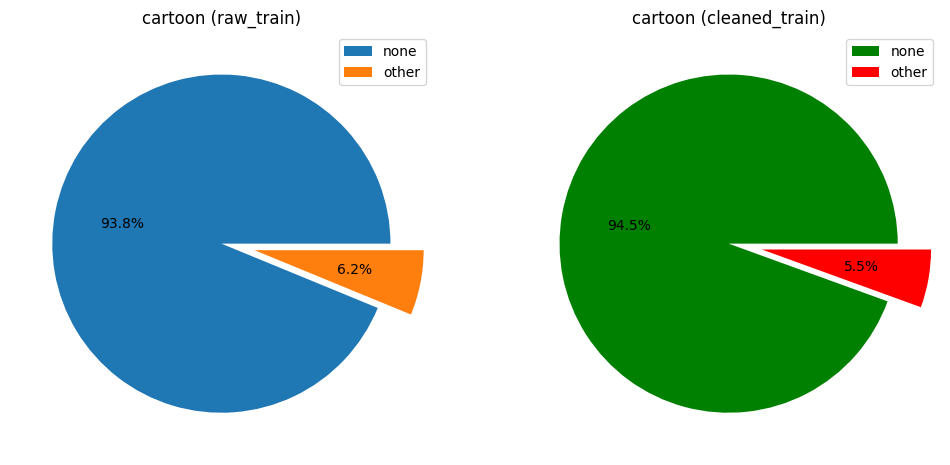

In [25]:
# график
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].pie(
    x=[
        raw_train["cartoon"].value_counts().loc["none"].sum(),
        raw_train["cartoon"].value_counts().drop("none", axis=0).sum(),
    ],
    autopct="%1.1f%%",
    explode=[0, 0.2],
)
axs[0].set_title("cartoon (raw_train)")
axs[0].legend(["none", "other"])

axs[1].pie(
    x=[
        cleaned_train["cartoon"].value_counts().loc["none"].sum(),
        cleaned_train["cartoon"].value_counts().drop("none", axis=0).sum(),
    ],
    autopct="%1.1f%%",
    explode=[0, 0.2],
    colors=["g", "r"],
)
axs[1].set_title("cartoon (cleaned_train)")
axs[1].legend(["none", "other"])

plt.show()

В целевой переменной ярко выражен дисбаланс классов. Почти 94% строк составляет класс **none**. В качестве решения данной проблемы можно рассмотреть сбор большего количества данных или двухступенчатую классификацию.  
  
Также среди пробем можно отметить мультиязычность в классах и потенциальную невозможность прямого перевода в связи с локализацией фильма за рубежом.

## Предобработка текста

Прежде всего проведём предобработку текстовых данных. Создадим промежуточный датафрейм, содержащий текстовую информацию.

### Подготовка

In [26]:
# исправление ошибки из-за некорректных типов данных
for col in cleaned_train.columns:
    cleaned_train[col] = cleaned_train[col].astype(str)

In [27]:
# разделение признаков на текстовые и нетекстовые
text_cols = ["text"]
other_cols = [col for col in cleaned_train.columns if col not in text_cols]

train_texts = cleaned_train[text_cols].copy()
train_others = cleaned_train[other_cols].copy()

### Обработка символов и ссылок

In [28]:
corpus = train_texts["text"].tolist()

In [29]:
corpus[:2]

['[100 подарков и только один можно оставить себе] ',
 '[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ Follow Me] ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ Follow Mehttps://youtu.be/Lcp0pFZF4eQ']

Составим функцию удаления различных ссылок, приведения текстов к нижему прегистру и удаляющую специальные символы.

In [30]:
def preprocess_text(text):
    """
    Проводит первичную предобработку текста
    """
    text = re.sub(r"https?://\S*", "", text)  # удаление https-ссылок
    text = re.sub(r"http?://\S*", "", text)  # удаление http-ссылок
    text = re.sub(r"<.*?>", "", text)  # удаление html-ссылок
    text = text.lower()  # приведение к нижнему регистру
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # заменяем пробелом дефисы
    text = re.sub(
        r"([^\w\s])", r"\1 ", text
    )  # добавление пробела после специального символа
    text = re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9\s]", "", text)  # удаление специальных символов

    return text

In [31]:
def generate_word_cloud(corpus):
    """
    Создаёт график "облаков слов"
    """
    # Объединяем все строки в одну
    combined_text = " ".join(corpus)

    # Создание облака слов
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", colormap="viridis"
    ).generate(combined_text)

    # Отображение облака слов
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Отключаем оси
    plt.show()

In [32]:
# применяем preprocess_text
train_texts["cleaned"] = train_texts.iloc[:, 0].progress_apply(preprocess_text)

  0%|          | 0/76684 [00:00<?, ?it/s]

In [33]:
# создаём корпус текстов в виде списка
corpus = train_texts["cleaned"].tolist()

In [34]:
# удаление лишних пробелов
for idx, text in enumerate(corpus):
    corpus[idx] = re.sub(r"\s{2,}", " ", text)

### Обработка стоп-слов и лемматизация текстов

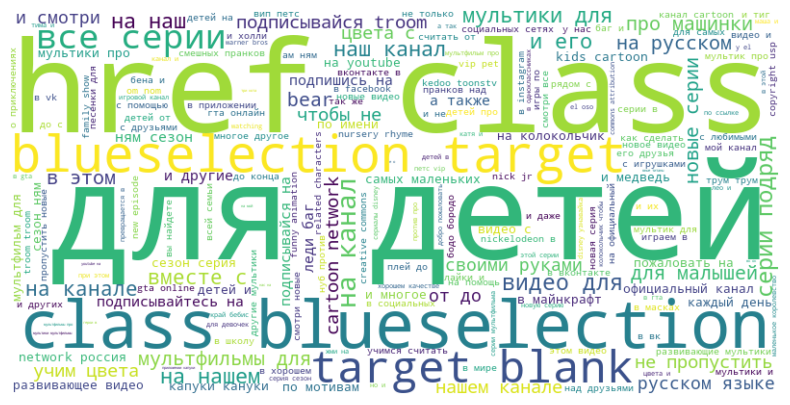

In [35]:
generate_word_cloud(corpus)

На основе визуального осмотра корпуса и составления "облака слов" были выделены некоторые фрагменты слов, которые можно добавить в фильтр для удаления из текстов.

In [36]:
user_sw_fragments = [
    "vkon",
    "вкон",
    "вк",
    "nickelod",
    "instagr",
    "tiktok" "x00",
    "dx0",
    "href",
    "class",
    "blueselection",
    "targ",
    "blank",
    "подпис",
    "subscri" "kids",
    "cartoo",
    "мульт" "facebo",
    "детск",
    "песен",
    "twitter",
]

In [37]:
def find_words(corpus, fragments):
    """Ищет слова, содержащие указанные фрагменты"""
    # множество слов
    found_words = set()

    for text in tqdm(corpus):
        # Разбиваем текст на слова
        words = text.split()

        # Проходим по каждому слову
        for word in words:
            # Проверяем, содержит ли слово хотя бы один из фрагментов
            if any(fragment in word for fragment in fragments):
                found_words.add(word)

    return found_words


user_stopwords = find_words(corpus, user_sw_fragments)

  0%|          | 0/76684 [00:00<?, ?it/s]

In [38]:
# загрузка модели spacy
# spacy.prefer_gpu()
nlp = spacy.load("ru_core_news_lg", disable=["parser", "ner"])

In [39]:
def process_corpus(corpus, user_sw, batch_size=50):
    """
    Производит обработку корпуса текстов,
    удаляет стоп-слова и производит лемматизацию
    """
    if user_sw is None:
        user_sw = []

    # обновление списка стоп-слов
    nlp.Defaults.stop_words.update(user_sw)

    # установка флага is_stop для новых стоп-слов
    for word in user_sw:
        lexeme = nlp.vocab[word]
        lexeme.is_stop = True

    # список обработанных текстов
    processed_texts = []

    for doc in tqdm(
        nlp.pipe(corpus, batch_size=batch_size),
        total=len(corpus),
        desc="Лемматизация текстов и удаление стоп-слов",
    ):

        lemmatized_words = [
            token.lemma_ for token in doc if not token.is_stop and not token.is_punct
        ]
        processed_sentence = " ".join(lemmatized_words)
        processed_sentence = re.sub(
            r"\s{2,}", " ", processed_sentence
        )  # удаление лишних пробелов
        processed_texts.append(processed_sentence)

    return processed_texts

## ЗАГРУЗКА ОБРАБОТАННОГО И СОХРАНЁННОГО КОРПУСА (TRAIN)

In [40]:
# cleaned_corpus = process_corpus(corpus, user_sw=user_stopwords, batch_size=100)
# df = pd.DataFrame({"text": cleaned_corpus})
# df.to_csv("C:/Users/Jemiah/Союзмультфильм/data/cleaned_corpus (one func).csv")

# загрузка предобработанного корпуса для оптимизации времени
cleaned_corpus = pd.read_csv(
    "C:/Users/Jemiah/Союзмультфильм/data/cleaned_corpus (one func).csv"
)["text"].tolist()

In [41]:
# df = pd.DataFrame({"text": cleaned_corpus})
# df.to_csv("C:/Users/Jemiah/Союзмультфильм/data/cleaned_corpus (one func).csv")

In [42]:
cleaned_corpus[:3]

[' 100 подарок оставить',
 ' забагали лизу реальный жизнь артур настя follow me забагали лизу реальный жизнь артур настя follow me',
 ' грозный семейка хороший сестринский момент хлои фиби нора опасный семейка девочка сандермен сплочённый команда сестра супергероев вместе фиби хлои нора сандермен весёлый вместе спасать мир зависать дома черепашкининдзя никелодеон никелодеонроссия henrydanger россияпривт ласкаво просимо офцйний канал ютуб знайдеш повн випуски улюблених шоу укранською мовою високй якост мультсерали черепашкинндзя губка боб квадратн штани гучний дм хлбокачки багато нших чекають нашому youtubeканал']

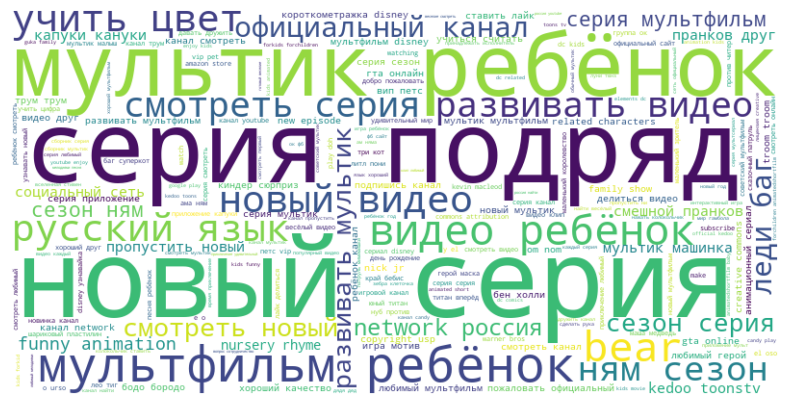

In [43]:
generate_word_cloud(corpus=cleaned_corpus)

## Сборка набора данных train

In [44]:
train_texts["text"] = cleaned_corpus
train = pd.merge(
    train_texts, train_others, left_index=True, right_index=True, how="left"
)

# Анализ (test)

In [45]:
print(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
dtypes: float64(4), object(11)
memory usage: 6.4+ MB
None


In [46]:
print(
    "Shorts, несоответствующие условиям платформы:",
    raw_test.query("is_shorts == 1 and (seconds > 60 or seconds < 15)").shape[0],
)
print(
    "Видео, несоответствующие условиям платформы:",
    raw_test.query("is_shorts == 0 and seconds == 0").shape[0],
)

Shorts, несоответствующие условиям платформы: 572
Видео, несоответствующие условиям платформы: 1192


## Обработка test для загрузки в модель

In [47]:
# применяем preprocess_text
raw_test["cleaned"] = raw_test["text"].progress_apply(preprocess_text)

  0%|          | 0/55608 [00:00<?, ?it/s]

In [48]:
# первращаем в корпус в виде списка
test_cleaned_corpus = raw_test["cleaned"].astype(str).tolist()

In [49]:
# удаление лишних пробелов
for idx, text in enumerate(test_cleaned_corpus):
    test_cleaned_corpus[idx] = re.sub(r"\s{2,}", " ", text)

In [50]:
len(test_cleaned_corpus)

55608

## ЗАГРУЗКА ОБРАБОТАННОГО И СОХРАНЁННОГО КОРПУСА (TEST)

In [51]:
# test_cleaned_corpus = process_corpus(test_cleaned_corpus, user_sw=user_stopwords, batch_size=100)
# df = pd.DataFrame({"text": test_cleaned_corpus})
# df.to_csv("C:/Users/Jemiah/Союзмультфильм/data/test_cleaned_corpus (one func).csv")

# загрузка предобработанного корпуса для оптимизации времени
test_cleaned_corpus = pd.read_csv(
    "C:/Users/Jemiah/Союзмультфильм/data/test_cleaned_corpus (one func).csv"
)

In [52]:
raw_test.loc[:, "text"] = test_cleaned_corpus

# Baseline-модель (TF-IDF + SVM)

## Подготовка данных

Для начала необходимо подготовить наборы данных для загрузки в модель и последующей проверки. Для этого создаём класс для удаления ненужных колонок. А также создадим отдельные объекты для признаков и целевого признака.

In [53]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, to_drop):
        self.to_drop = to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.to_drop)

In [54]:
# список столбцов, которые необходимо удалить из train
cols_to_drop_train = [
    col
    for col in raw_test.columns
    if col not in ["text", "yt_channel_name", "yt_channel_type", "cartoon"]
]

# список столбцов, которые необходимо удалить из test
cols_to_drop_test = [
    col
    for col in raw_test.columns
    if col not in ["yt_reel_id", "text", "yt_channel_name", "yt_channel_type"]
]

In [55]:
# иницализация дроппера столбцов (train)
train_dropper = ColumnDropper(to_drop=cols_to_drop_train)

# инициализация дроппера столбцов (test)
test_dropper = ColumnDropper(to_drop=cols_to_drop_test)

In [56]:
train = train_dropper.fit_transform(train)
X_test = test_dropper.fit_transform(raw_test)

In [57]:
X = train.drop(columns="cartoon")
y = train["cartoon"]
X_test_ids = raw_train["yt_reel_id"]

## Формирование выборок

In [58]:
# тренировочная и валидационная выборки 4:1
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

## Подбор гиперпараметров RandomizedSearchCV

In [59]:
def hyperparameters_selection_RSCV(
    model, params, X, y, n_iter=10, cv=5, n_jobs=-1, verbose=0
):
    """
    Данная функция обучает модель и проводит подбор гиперпараметров
    методом рандомизированной кросс-валидации

    Возвращает: лучшие параметры, лучшую метрику, лучшую модель
    и обученные преобразователи-признаков
    """
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first").fit(
        X[["yt_channel_name", "yt_channel_type"]]
    )
    tfidf = TfidfVectorizer().fit(X["text"])
    pipeline = Pipeline(
        steps=[
            # ('drop_columns', FunctionTransformer(drop_unwanted_columns)),
            (
                "preprocessor",
                ColumnTransformer(
                    transformers=[
                        (
                            "text",
                            tfidf,
                            "text",
                        ),  # Векторизация текстовой колонки
                        (
                            "encoder",
                            ohe,
                            ["yt_channel_name", "yt_channel_type"],
                        ),
                        # ('others', 'passthrough', [col for col in other_cols if col != "cartoon"])
                    ]
                ),
            ),
            ("classifier", model),  # модель-классификатор
        ]
    )

    # инициализация RandomizedSearchCV
    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring="f1_macro",
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
    )

    with tqdm(total=n_iter * cv) as pbar:
        for i in range(n_iter):
            grid.fit(X, y)
            pbar.update(1)

    return (grid.best_params_, grid.best_score_, grid.best_estimator_, ohe, tfidf)

In [60]:
# гиперпараметры SVC-модели для подобора методом RandomizedSearch
params = {
    "classifier__C": np.arange(0.5, 2.5, 0.5),
    "classifier__kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
    "classifier__degree": range(1, 7),
}

In [61]:
# par, scr, mdl, ohe, tfidf = hyperparameters_selection_RSCV(
#     model=SVC(random_state=RANDOM_STATE),
#     params=params,
#     X=X_train,
#     y=y_train,
#     n_iter=3,
#     cv=2,
# )

svc_classifier = pd.read_pickle("C:/Users/Jemiah/Союзмультфильм/models/svc_default.pkl")

## Валидация лучшей модели

Лучшие гиперпараметры на RandomizedSearchCV (10 итераций): {'kernel': 'linear', 'degree': 2, 'C': 2.0}

In [62]:
preds = svc_classifier.predict(X_val)

In [63]:
res = f1_score(preds, y_val, average="macro")

In [69]:
print(f"Average F1-score: {res:.2f}")

Average F1-score: 0.62


### Функции сохранения и загрузки обученных моделей

In [65]:
##########################
#   SAVE using pickle    #
##########################
def save_model(model, saving_path="C:/Users/", filename="model_1"):
    with open(saving_path + filename + ".pkl", "wb") as f:
        pickle.dump(pipeline, f)


##########################
#   LOAD using pickle    #
##########################
def load_model(loading_path="C:/Users/", filename="model_1"):
    with open(saving_path + filename + ".pkl", "rb") as f:
        return pickle.load(f)

Сводка и сохранение результатов работы лучшей модели.

In [66]:
# print(classification_report(y_val, grid_preds, zero_division=0))

In [67]:
# preds = pd.DataFrame({"yt_reel_id": test_ids, "cartoon": pipeline.predict(test)})
# print(preds.head())

In [68]:
# preds.to_csv("C:/Users/Jemiah/Союзмультфильм/data/best_svc_preds.csv", index=False)

# Заключение

В данной работе для получения модели, определяющей принадлежность видеоролика на основе обработки данных естественного языка были выполнены:  
1. Исследовательский анализ данных.
2. Предобработка полученных данных.
3. Подготовка данных для загрузки в модель.
4. Обучение модели, валидация и проверка на тестовой выборке, предоставленной заказчиком.

<font size=5><b> Исследовательский анализ и предобработка данных </b></font>  
<p style="text-align: justify;"">В ходе анализа были выявлены признаки, которые наиболее подходят для создания модели. Большинство признаков можно назвать вспомогательными, поскольку как таковой информации о тематике видеоролика в них не имеется. К тому же часть из них являются бинарными категориальными признаками, с выраженным дисбалансом классов. Под термином "вспомогательные" имеется в виду то, что такие признаки могут быть использованы для так называемой "проверки на адекватность" объектов данных. Данные которые нарушают логику объекта или процесса для которого были собраны (например, граничные условия, ведь если видеоролик принадлежит категории shorts, то он не может длиться, скажем, 30 минут, ведь это противоречит протоколу платформы) как минимум бесполезны, а как максимум могут исказить модель. В данном случае были проведены некоторые подобные проверки, что привело к удалению некачественных объектов. Также были предобработаны дубликаты. Пропуски не обрабатывались, поскольку были обнаружены в колонках с признаками, не использующимися в модели. Основную часть работы составила обработка текстовых признаков. Для того чтобы научить модель классифицировать тексты, требуется выполнить несколько процедур, которые избавят текст от бесполезных символов, ссылок и так называемых стоп-слов (например удаление символов, различных частиц и союзов, поскольку первые не несут классификационной информации, а вторые помимо прочего часто встречаются и могут перегрузить и запутать модель). Список стоп-слов, который предоставляют библиотеки пришлось расширять вручную из-за специфики задачи. Также были обнаружены опечатки, и наличие слов или текстов на иностранных языках (см. P.S.).</p>

<font size=5><b> Обучение и валидация модели </b></font>  
<p style="text-align: justify;"">Наилучшей моделью в данной работе себя показала модель Support Vector Machines (SVClassifier). Метрика <b>average F1-score</b> на тестовых данных, предоставленных заказчиком, составила ~ 0.81. </p>

<font size=5><b> P.S. для ревьюера</b></font>  
<p style="text-align: justify;""> В связи с непредвиденными обстоятельствами я не смог насладиться данным проектом в полную силу. Прошу меня простить. Немного расскажу о том, что хотел бы сделать и что не получилось. Во-первых разнообразие языков, которое обнаружилось в текстах, я планировал либо перевести либо разделить по колонкам. Во втором случае, это приводило к большому количеству пустых мест, которые я не придумал чем заполнить и этот метод отпал, поэтому пришлось искать методы перевода. К сожалению ни одна библиотека для перевода не завелись и я пошёл учить модель на том, что имею. Была попытка обучить несколько моделей, и по-разному проводить векторизацию текстов. Однако пользуясь GloVe или Sentence Transformers модели показывали результат гораздо более плохой чем с TF-IDF, и я не успел исправить ситуацию. Вероятно это было связано с наличием опечаток и мультиязычностью. В любом случае это был интересный проект и я планирую его допилить. Жду обратную связь!!! Большое спасибо! </p>